In [1]:
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import mplhep
from matplotlib.colors import LogNorm
from joblib import dump, load

In [2]:
#proton_selection = "SingleRP"
proton_selection = "MultiRP"

## Signal

In [3]:
#df_signal = None
#event_counts_signal = None
#selections_str_signal = None

df_signal_list = []
df_counts_signal_list = []

fileNames_signal = [
    'output/output-MC2017-Elastic-Non3+3-PreSel.h5'
    #'output-MC2017-SingleDissociation-PreSel.h5'
]

for file_ in fileNames_signal:
    print ( file_ )
    with h5py.File( file_, 'r' ) as f:
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )
        
        dset_counts = f['event_counts']
        df_counts_signal_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_signal_list[-1] )
        
        df_ = pd.DataFrame( dset, columns=columns_str )
        df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                    'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                    'Xi', 'T', 'ThX', 'ThY', 'Time',
                    'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
        df_signal_list.append( df_ )
        print ( df_signal_list[-1].head() )
        print ( len( df_signal_list[-1] ) )    

output/output-MC2017-Elastic-Non3+3-PreSel.h5
['columns', 'event_counts', 'protons', 'selections']
(213536, 38)
[[1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 9.1376482e-04
  2.3529863e-02 4.4119707e-03]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 [1.0000000e+00 1.0000000e+00 4.2949673e+09 ... 8.7998388e-04
  4.5879604e-03 8.1510313e-02]
 ...
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 2.6697566e-04
  2.1097749e-03 4.5376737e-02]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]
 [1.0000000e+00 7.5600000e+02 4.2949673e+09 ... 1.8521260e-04
  3.6291495e-02 3.0596652e-03]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP

In [4]:
df_counts_signal = df_counts_signal_list[0]
for idx in range( 1, len( df_counts_signal_list ) ):
    df_counts_signal = df_counts_signal.add( df_counts_signal_list[idx] )
df_counts_signal

All        178402
Muon       166756
Vertex     149608
Protons     91429
dtype: int64

In [5]:
df_signal = pd.concat( df_signal_list )

In [6]:
msk_sig = ( df_signal["InvMass"] >= 110. )

msk1_sig = None
msk2_sig = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_signal["RPId1"] == 23 )
    msk2_arm = ( df_signal["RPId1"] == 123 )
    df_signal[ "XiMuMu" ] = np.nan
    df_signal[ "XiMuMu" ].where( ~msk1_arm, df_signal[ "XiMuMuPlus" ], inplace=True )
    df_signal[ "XiMuMu" ].where( ~msk2_arm, df_signal[ "XiMuMuMinus" ], inplace=True )
    #df_signal[ "XiMuMu" ][ msk2_arm ] = df_signal[ "XiMuMuMinus" ] 
    msk1_sig = msk_sig & ( df_signal["MultiRP"] == 0) & msk1_arm
    msk2_sig = msk_sig & ( df_signal["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_signal["Arm"] == 0 )
    msk2_arm = ( df_signal["Arm"] == 1 )
    df_signal[ "XiMuMu" ] = np.nan
    df_signal[ "XiMuMu" ].where( ~msk1_arm, df_signal[ "XiMuMuPlus" ], inplace=True )
    df_signal[ "XiMuMu" ].where( ~msk2_arm, df_signal[ "XiMuMuMinus" ], inplace=True )
    msk1_sig = msk_sig & ( df_signal["MultiRP"] == 1 ) & msk1_arm
    msk2_sig = msk_sig & ( df_signal["MultiRP"] == 1 ) & msk2_arm

df_signal = df_signal[ msk1_sig | msk2_sig ]
df_signal[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
3,1,1,3,150.0,1,1,103,123,7.630859,1.224731,...,0.000023,0.0,115.289131,114.552933,251.395355,16,0.000880,0.004588,0.081510,0.081510
6,1,1,12,150.0,1,0,3,23,5.149414,0.725220,...,0.000011,0.0,55.317619,52.814793,126.690613,4,0.001160,0.055618,0.001708,0.055618
16,1,1,17,150.0,1,1,103,123,3.828247,0.749878,...,0.000012,0.0,61.452324,60.853138,263.130524,1,0.000028,0.008177,0.050104,0.050104
19,1,1,30,150.0,1,0,3,23,5.139893,0.158340,...,0.000055,0.0,52.522842,51.576660,176.417725,1,0.001032,0.046055,0.003999,0.046055
24,1,1,13,150.0,1,1,103,123,2.742798,0.001996,...,0.000114,0.0,117.683517,115.790192,233.975662,17,0.000317,0.007711,0.042010,0.042010
27,1,1,31,150.0,1,1,103,123,5.258789,-0.745728,...,0.000083,0.0,84.892128,72.441437,266.681091,0,0.001807,0.006805,0.061971,0.061971
30,1,1,37,150.0,1,0,3,23,4.975342,1.117432,...,-0.000015,0.0,69.889496,66.498047,176.964508,0,0.000757,0.054292,0.003414,0.054292
42,1,1,52,150.0,1,0,3,23,7.566895,0.678040,...,0.000004,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.072588
43,1,1,52,150.0,1,1,103,123,11.388184,3.717285,...,-0.000008,0.0,299.492554,274.796112,1466.510620,2,0.000317,0.072588,0.175365,0.175365
46,1,1,57,150.0,1,1,103,123,3.813232,1.491821,...,-0.000037,0.0,58.605152,56.575214,115.234695,0,0.000651,0.001538,0.051120,0.051120


## Background

In [7]:
df_bkg_list = []
df_counts_bkg_list = []

resample_factor = 20

fileNames_bkg = [
    'output/output-UL2017B-PreSel-Rnd-Res20.h5',
    'output/output-UL2017C1-PreSel-Rnd-Res20.h5',
    'output/output-UL2017E-PreSel-Rnd-Res20.h5',
    'output/output-UL2017F1-PreSel-Rnd-Res20.h5'
]

for file_ in fileNames_bkg:
    with h5py.File( file_, 'r' ) as f:
        print ( file_ )    
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
        
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )
        
        dset_counts = f['event_counts']
        df_counts_bkg_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_bkg_list[-1] )
       
        chunk_size = 1000000
        entries = dset.shape[0]
        start_ = list( range( 0, entries, chunk_size ) )
        stop_ = start_[1:]
        stop_.append( entries )
        print ( start_ )
        print ( stop_ )
        for idx in range( len( start_ ) ):
            print ( start_[idx], stop_[idx] )
            #print ( dset[ start_[idx] : stop_[idx] ] )
            df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
            df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                        'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                        'Xi', 'T', 'ThX', 'ThY', 'Time',
                        'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
            df_bkg_list.append( df_ )
            print ( df_bkg_list[-1].head() )
            print ( len( df_bkg_list[-1] ) )

output/output-UL2017B-PreSel-Rnd-Res20.h5
['columns', 'event_counts', 'protons', 'selections']
(2141500, 38)
[[2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 ...
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_MultiRP', 

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  300560           97  116191336          120.0        1    1    103    123   
1  300560           97  116776680          120.0        0 -999    103     -1   
2  300560           97  116776680          120.0        0 -999    123     -1   
3  300560           97  116776680          120.0        1    1    103    123   
4  300560           97  115898864          120.0        0 -999      3     -1   

     TrackX1   TrackY1  ...       ThX       ThY      Time     Muon0Pt  \
0   3.778931  0.876831  ... -0.000016  0.000021  0.000000  136.861618   
1  12.148926  1.382080  ...  0.000000 -0.000023  0.000000  191.480087   
2  12.212402  1.428955  ...  0.000000 -0.000022  0.000000  191.480087   
3  12.148926  1.382080  ...  0.000047  0.000077  0.042752  191.480087   
4   9.083984  2.758789  ...  0.000000 -0.000102  0.000000   85.710884   

     Muon1Pt     InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  8

      Run  LumiSection    EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  304292         1201  1823432832          120.0        0 -999    103     -1   
1  304292         1201  1823432832          120.0        0 -999    123     -1   
2  304292         1201  1823432832          120.0        1    1    103    123   
3  304292         1201  1822685568          120.0        0 -999    103     -1   
4  304292         1202  1824409472          120.0        0 -999     23     -1   

     TrackX1   TrackY1  ...       ThX       ThY      Time    Muon0Pt  \
0   9.696777 -1.657959  ...  0.000000  0.000032  0.000000  72.365654   
1   9.554810 -1.816406  ...  0.000000  0.000033  0.000000  72.365654   
2   9.696777 -1.657959  ... -0.000011  0.000143  0.056396  72.365654   
3  10.411133  5.502930  ...  0.000000 -0.000110  0.000000  88.793587   
4   3.107452  0.325287  ...  0.000000 -0.000074  0.000000  62.810257   

     Muon1Pt     InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  5

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  303832          784  945486976          130.0        0 -999    123     -1   
1  303832          784  945486976          130.0        0 -999    123     -1   
2  303832          785  946738368          130.0        0 -999    123     -1   
3  303832          785  946738368          130.0        0 -999    123     -1   
4  303832          785  946738368          130.0        0 -999    123     -1   

     TrackX1   TrackY1  ...  ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0   4.496155 -0.163849  ...  0.0  0.000008   0.0  93.677650  52.272697   
1   8.725220  0.732239  ...  0.0 -0.000015   0.0  93.677650  52.272697   
2  13.152222  2.567627  ...  0.0 -0.000032   0.0  83.052345  57.182045   
3  16.280029 -8.955078  ...  0.0  0.000087   0.0  83.052345  57.182045   
4  17.005615 -1.174072  ...  0.0  0.000011   0.0  83.052345  57.182045   

     InvMass  ExtraPfCands     Acopl  XiMuMuPlus  XiMuMuMinus  
0  91.1175

      Run  LumiSection   EventNum  CrossingAngle  MultiRP  Arm  RPId1  RPId2  \
0  305081          172  235603664          150.0        0 -999    123     -1   
1  305081          172  235603664          150.0        1    0      3     23   
2  305081          172  235603664          150.0        1    1    103    123   
3  305081          172  235748784          150.0        0 -999      3     -1   
4  305081          172  235748784          150.0        0 -999     23     -1   

     TrackX1   TrackY1  ...       ThX       ThY  Time    Muon0Pt    Muon1Pt  \
0  10.326782 -2.386475  ...  0.000000  0.000034   0.0  91.016975  72.235619   
1   4.918945 -0.112457  ...  0.000191  0.000087   0.0  91.016975  72.235619   
2  10.731934 -2.184814  ... -0.000052  0.000245   0.0  91.016975  72.235619   
3  13.570312  5.555664  ...  0.000000 -0.000112   0.0  93.529984  75.133713   
4   2.975891  0.609863  ...  0.000000 -0.000161   0.0  93.529984  75.133713   

     InvMass  ExtraPfCands     Acopl  XiMuMu

In [8]:
df_counts_bkg = df_counts_bkg_list[0]
for idx in range( 1, len( df_counts_bkg_list ) ):
    df_counts_bkg = df_counts_bkg.add( df_counts_bkg_list[idx] )
df_counts_bkg

All           869119560
Muon            8456020
Vertex          7782360
ProtonsRnd      6301680
dtype: int64

In [9]:
df_bkg = pd.concat( df_bkg_list )

In [10]:
msk_bkg = ( df_bkg["InvMass"] >= 110. )

msk1_bkg = None
msk2_bkg = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_bkg["RPId1"] == 23 )
    msk2_arm = ( df_bkg["RPId1"] == 123 )
    df_bkg[ "XiMuMu" ] = np.nan
    df_bkg[ "XiMuMu" ].where( ~msk1_arm, df_bkg[ "XiMuMuPlus" ], inplace=True )
    df_bkg[ "XiMuMu" ].where( ~msk2_arm, df_bkg[ "XiMuMuMinus" ], inplace=True )
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 0) & msk1_arm
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_bkg["Arm"] == 0 )
    msk2_arm = ( df_bkg["Arm"] == 1 )
    df_bkg[ "XiMuMu" ] = np.nan
    df_bkg[ "XiMuMu" ].where( ~msk1_arm, df_bkg[ "XiMuMuPlus" ], inplace=True )
    df_bkg[ "XiMuMu" ].where( ~msk2_arm, df_bkg[ "XiMuMuMinus" ], inplace=True )
    msk1_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & msk1_arm
    msk2_bkg = msk_bkg & ( df_bkg["MultiRP"] == 1 ) & msk2_arm

df_bkg = df_bkg[ msk1_bkg | msk2_bkg ]
df_bkg[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
10,297227,56,38791640,120.0,1,0,3,23,7.063232,1.953613,...,-4.635066e-05,0.0,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.002211
20,297227,58,40362008,120.0,1,0,3,23,7.391113,2.280518,...,-1.740635e-05,0.0,80.369690,68.791176,228.323425,10,0.271141,0.028539,0.011619,0.028539
33,297227,60,41478176,120.0,1,0,3,23,6.782959,1.464966,...,-5.399367e-05,0.0,114.150841,93.884605,323.668549,40,0.157789,0.035037,0.018197,0.035037
47,297227,63,44189296,120.0,1,0,3,23,13.382812,-1.072510,...,6.678360e-05,0.0,138.408752,108.538467,245.222839,53,0.008506,0.033806,0.010684,0.033806
69,297227,73,52238048,120.0,1,1,103,123,8.629883,1.481323,...,7.347923e-05,0.0,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333
84,297227,75,53449356,120.0,1,1,103,123,5.546875,1.592651,...,6.509769e-07,0.0,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.007848
93,297227,76,54126336,120.0,1,0,3,23,8.200684,3.784912,...,-7.809676e-05,0.0,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.049092
111,297227,78,55898044,120.0,1,1,103,123,3.611084,1.855103,...,-1.616523e-05,0.0,58.097786,53.140121,126.642601,84,0.273834,0.032531,0.003312,0.003312
118,297227,79,56863080,120.0,1,1,103,123,3.396606,1.380615,...,-2.309114e-05,0.0,61.966732,50.172760,127.597572,21,0.026694,0.001631,0.059633,0.059633
138,297227,86,61943160,120.0,1,0,3,23,7.637451,1.072144,...,-4.634655e-05,0.0,91.612099,71.395660,163.843567,62,0.095938,0.016999,0.009692,0.016999


### Select variables

In [11]:
X_sig = df_signal[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
X_sig[:20]

,Xi,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMu
3,0.079777,115.289131,114.552933,251.395355,16,0.000880,0.081510
6,0.058544,55.317619,52.814793,126.690613,4,0.001160,0.055618
16,0.052047,61.452324,60.853138,263.130524,1,0.000028,0.050104
19,0.045926,52.522842,51.576660,176.417725,1,0.001032,0.046055
24,0.041798,117.683517,115.790192,233.975662,17,0.000317,0.042010
27,0.073885,84.892128,72.441437,266.681091,0,0.001807,0.061971
30,0.055212,69.889496,66.498047,176.964508,0,0.000757,0.054292
42,0.076750,299.492554,274.796112,1466.510620,2,0.000317,0.072588
43,0.173075,299.492554,274.796112,1466.510620,2,0.000317,0.175365
46,0.050896,58.605152,56.575214,115.234695,0,0.000651,0.051120


In [12]:
X_bkg = df_bkg[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
X_bkg[:20]

,Xi,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMu
10,0.087538,65.270454,65.022888,152.786011,29,0.058782,0.002211
20,0.094858,80.369690,68.791176,228.323425,10,0.271141,0.028539
33,0.053182,114.150841,93.884605,323.668549,40,0.157789,0.035037
47,0.101070,138.408752,108.538467,245.222839,53,0.008506,0.033806
69,0.110202,86.516212,56.114479,138.904510,10,0.060892,0.008333
84,0.076194,74.069061,62.750038,159.699677,53,0.023202,0.007848
93,0.079165,75.266441,69.694183,223.032425,59,0.145185,0.049092
111,0.063853,58.097786,53.140121,126.642601,84,0.273834,0.003312
118,0.055931,61.966732,50.172760,127.597572,21,0.026694,0.059633
138,0.074558,91.612099,71.395660,163.843567,62,0.095938,0.016999


In [13]:
y_sig = np.ones( len(X_sig) )
y_bkg = np.zeros( len(X_bkg) )

X = pd.concat( [X_sig, X_bkg] ) 
y = np.concatenate( [y_sig, y_bkg] )

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, shuffle=True, random_state=42 )

In [15]:
clf = None

load_keras_model = True

# If not using Keras 
train_model = False
save_model = False

if load_keras_model:
    import tensorflow as tf
    from tensorflow import keras
    clf = keras.models.load_model( "model/keras_model.h5" )
else:
    if train_model:
        from sklearn.tree import DecisionTreeClassifier
        from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
    
        ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier( max_depth=4 ),
            n_estimators = 200,
            algorithm="SAMME.R",
            learning_rate = 0.5)
        ada_clf.fit( X_train, y_train )
        clf = ada_clf
    
        if save_model:
            dump( clf, "model/ada_clf.joblib" )
    else:
        clf = load( "model/ada_clf.joblib" )

print ( clf )
if load_keras_model:
    clf.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_101 (Dropout)        (None, 7)                 0         
_________________________________________________________________
dense_101 (Dense)            (None, 50)                400       
_________________________________________________________________
dropout_102 (Dropout)        (None, 50)                0         
_________________________________________________________________
dense_102 (Dense)            (None, 1)                 51        
Total params: 451
Trainable params: 451
Non-trainable params: 0
_________________________________________________________________


In [16]:
#features_ = ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu']
#for name, score in zip( features_, clf.feature_importances_ ):
#    print( name, score )

### Run cross validation

In [17]:
#y_train_scores = clf.decision_function( X_train )
#from sklearn.model_selection import cross_val_score
#y_scores = cross_val_score( clf, X_train, y_train, cv=3, n_jobs=-1)
#print ( y_scores )

### Predict on test set

In [18]:
scaler = None
X_test_scaled = None
y_test_proba = None

if load_keras_model:
    scaler = load( "model/standard_scaler.joblib" )
    print ( scaler )
    X_test_scaled = scaler.transform( X_test )
    print( X_test_scaled )
    y_test_proba = clf.predict( X_test_scaled )
    y_test_proba = y_test_proba.flatten()
else: 
    y_test_proba = clf.predict_proba( X_test )[:,1]

print ( y_test_proba )

StandardScaler()
[[ 0.63218591 -0.0180658   0.09680367 ... -0.46477492 -0.5770744
  -0.71503833]
 [ 0.77642334 -0.64613517 -0.44423348 ... -1.36995147 -0.59563192
  -0.45580913]
 [ 2.07014795 -0.49306826 -0.42273511 ...  1.16454285 -0.18425629
  -0.63191615]
 ...
 [-0.78192725 -0.67984619 -0.58260008 ... -0.96262202 -0.51113171
  -0.19100818]
 [-0.22718798 -0.58577204 -0.54864803 ... -0.78158671 -0.2199695
  -0.09855924]
 [ 0.17484322 -0.66070651 -0.4097657  ...  1.25506051 -0.57340569
  -0.77896504]]
[5.5896590e-04 1.8495375e-03 1.3954027e-05 ... 1.1412134e-02 3.5700884e-03
 1.5500173e-04]


### Run ROC curve

In [19]:
#print ( y_train_scores[ y_train == 0 ] )
#print ( y_train_scores[ y_train == 1 ] )
#
#fig = plt.figure( figsize=(10,10) )
#range_ = ( y_train_scores.min(), y_train_scores.max() )
#plt.hist( y_train_scores[ y_train == 0 ], color='orange', alpha=0.20, bins=20, range=range_ )
#plt.hist( y_train_scores[ y_train == 1 ], color='skyblue', alpha=0.60, bins=20, range=range_ )

In [20]:
#y_test_proba = clf.predict_proba( X_test )[:,1]

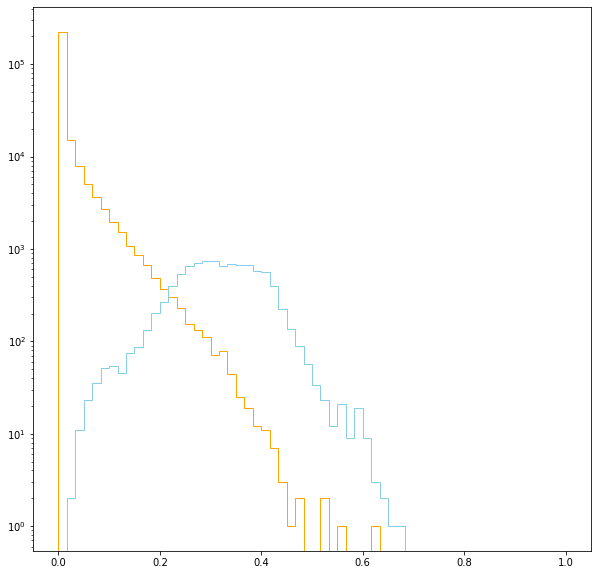

In [21]:
fig = plt.figure( figsize=(10,10) )
plt.hist( y_test_proba[ y_test == 0 ], histtype='step', color='orange', bins=60, range=(0.,1.) )
plt.hist( y_test_proba[ y_test == 1 ], histtype='step', color='skyblue', bins=60, range=(0.,1.) )
plt.yscale('log')

[0.         0.         0.         ... 0.99942834 0.99943586 1.        ] [0.00000000e+00 1.04101603e-04 6.24609619e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00] [1.6820281e+00 6.8202806e-01 6.2503052e-01 ... 5.7843671e-08 5.7760772e-08
 2.6191161e-12]


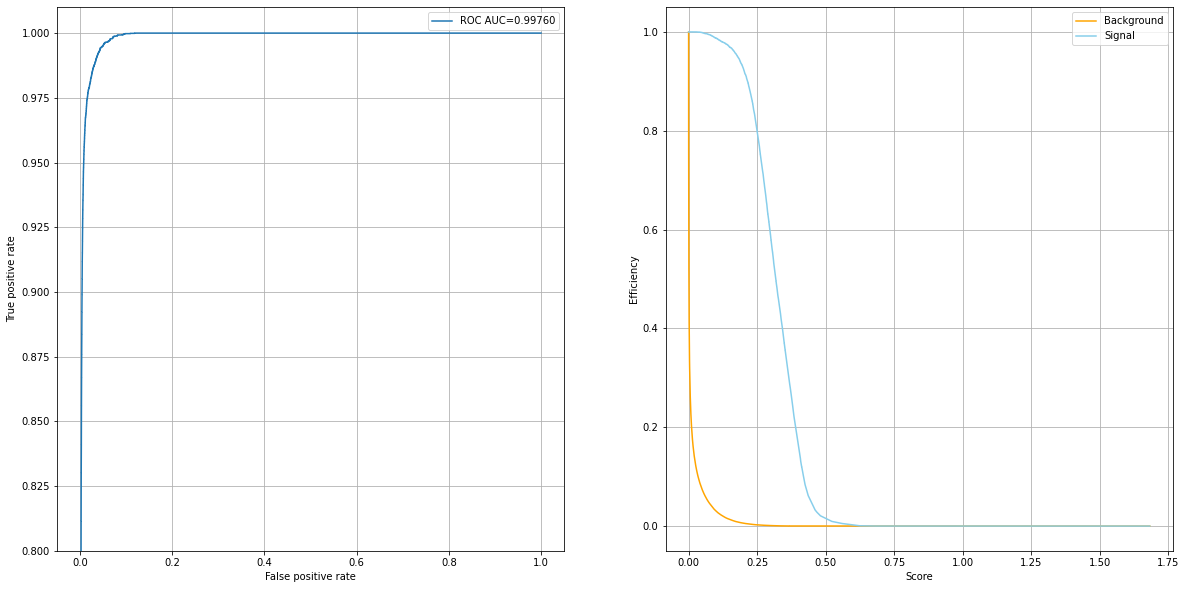

In [22]:
from sklearn.metrics import roc_curve,roc_auc_score

fpr, tpr, thresholds = roc_curve( y_test, y_test_proba )
auc = roc_auc_score(y_test, y_test_proba)

print ( fpr, tpr, thresholds )

fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

axes[0].plot(fpr, tpr, label="ROC AUC={:.5f}".format(auc))
axes[0].legend(loc='best')
axes[0].set_xlabel( 'False positive rate' )
axes[0].set_ylabel( 'True positive rate' )
axes[0].set_ylim(0.80,1.01)
axes[0].grid()

#axes[0].plot(tpr,
#             np.divide(np.ones_like(fpr), fpr, out=np.zeros_like(fpr), where=fpr!=0), 
#             label="ROC AUC={:.5f}".format(auc))
#axes[0].legend(loc='best')
#axes[0].set_ylabel('Background rejection (1/false positive rate)')
#axes[0].set_xlabel('Signal efficiency (true positive rate)')
#axes[0].set_xlim(0.88,1.0)
#axes[0].grid()

axes[1].plot(thresholds,fpr,label='Background', color='orange')
axes[1].plot(thresholds,tpr,label='Signal', color='skyblue')
axes[1].set_xlabel('Score')
axes[1].set_ylabel('Efficiency')
axes[1].legend()
axes[1].grid()
#axes[1].set_xscale('log')
#axes[1].set_yscale('log')

In [23]:
prob_cut = 0.20
y_test_pred = None

if load_keras_model:
    y_test_pred = ( y_test_proba >= prob_cut ).astype( "int32" )
    y_test_pred = y_test_pred.flatten()
else: 
    y_test_pred = clf.predict( X_test )

print ( y_test_pred )

[0 0 0 ... 0 0 0]


In [24]:
from sklearn.metrics import accuracy_score

accuracy_score( y_test, y_test_pred )

0.9917059288996654

(0.0, 0.15)

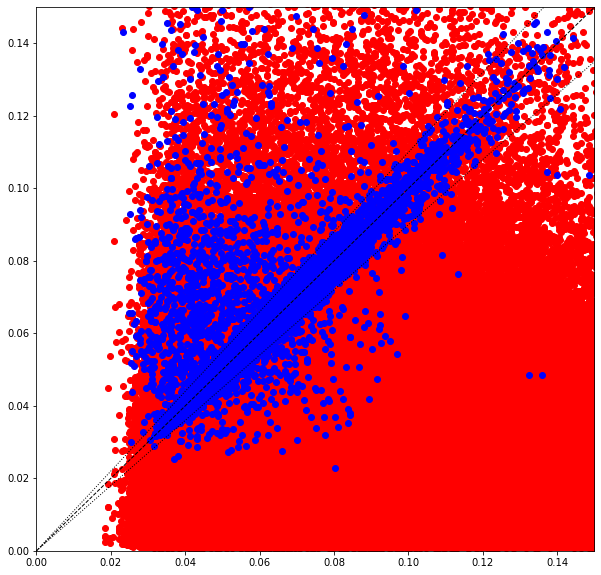

In [25]:
fig= plt.figure( figsize=(10,10) )

msk_bkg = ( y_test_pred == 0 )
msk_sig = ( y_test_pred == 1 )

plt.plot( X_test[ "Xi" ][ msk_bkg ], X_test[ "XiMuMu" ][ msk_bkg ], 'ro' )
plt.plot( X_test[ "Xi" ][ msk_sig ], X_test[ "XiMuMu" ][ msk_sig ], 'bo' )
plt.plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
plt.plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
plt.plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
plt.xlim(0.,0.15)
plt.ylim(0.,0.15)

(array([67.84132667, 68.41340135, 64.50983295, 59.93323552, 60.5726131 ,
        53.7413684 , 58.58717745, 57.47667954, 57.71223971, 56.70269615,
        51.99149291, 53.23659663, 52.15975017, 51.85688711, 54.88551776,
        56.76999906, 51.38576678, 57.10651357, 54.51535179, 53.84232276,
        48.55904484, 51.58767549, 49.80414855, 50.61178339, 49.40033113,
        47.75141   , 50.14066307, 45.66501999, 45.39580838, 45.09294531,
        46.43900338, 45.59771709, 49.43398258, 45.22755112, 45.96788305,
        46.00153451, 46.10248886, 45.73232289, 47.04472951, 46.70821499,
        41.42493707, 42.13161756, 41.49223998, 41.82875449, 40.88651384,
        39.97792465, 38.56456368, 39.80966739, 40.24713626, 42.13161756]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.01

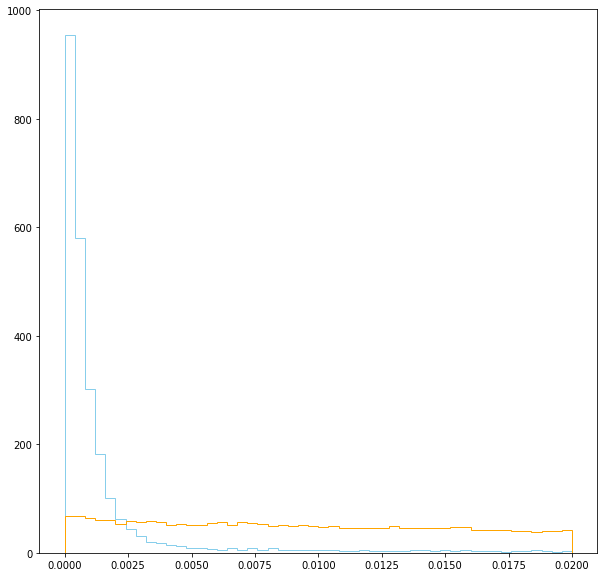

In [26]:
fig = plt.figure( figsize=(10,10) )
plt.hist( X_test[ "Acopl" ][ y_test_pred == 1 ], histtype='step', color='skyblue', bins=50, range=(0.,0.02), density=True )
plt.hist( X_test[ "Acopl" ][ y_test_pred == 0 ], histtype='step', color='orange', bins=50, range=(0.,0.02), density=True )

(array([0.00299655, 0.00274087, 0.00354371, 0.00506755, 0.0064431 ,
        0.00726127, 0.00902546, 0.01018112, 0.0113777 , 0.01325438,
        0.0132237 , 0.01502368, 0.01626116, 0.01797932, 0.01916567,
        0.01972305, 0.02069974, 0.0223054 , 0.02192189, 0.02377811,
        0.02269915, 0.02397754, 0.02338948, 0.02560366, 0.02596672,
        0.02487242, 0.02574172, 0.0267491 , 0.02634001, 0.02629399,
        0.02736273, 0.02678489, 0.02677467, 0.02659058, 0.02508207,
        0.0253173 , 0.02453492, 0.02396731, 0.02480083, 0.02422299,
        0.02371164, 0.02376788, 0.02231563, 0.02242813, 0.0211753 ,
        0.02037759, 0.0203827 , 0.01993782, 0.01929351, 0.0375643 ]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 [<matplotlib.patches.Polygon

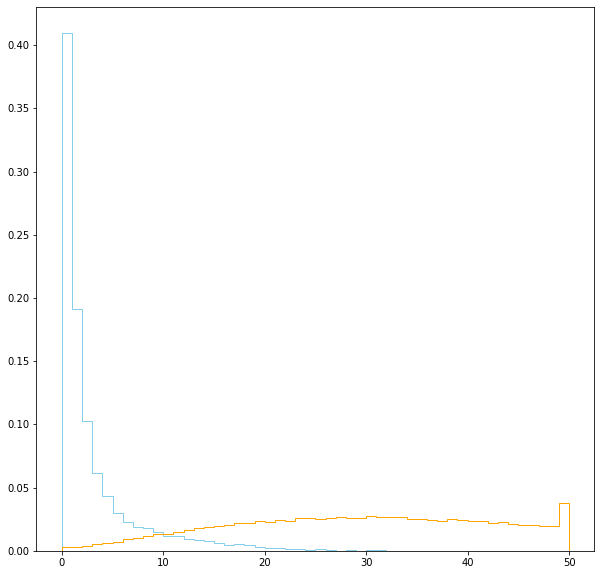

In [27]:
fig = plt.figure( figsize=(10,10) )
plt.hist( X_test[ "ExtraPfCands" ][ y_test_pred == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True )
plt.hist( X_test[ "ExtraPfCands" ][ y_test_pred == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True )

### Inspect signal and background sets

In [28]:
X_sig_scaled = None
X_bkg_scaled = None
y_sig_proba = None
y_sig_pred = None
y_bkg_proba = None
y_bkg_pred = None

if load_keras_model:
    X_sig_scaled = scaler.transform( X_sig )
    print( X_sig_scaled )
    X_bkg_scaled = scaler.transform( X_bkg )
    print( X_bkg_scaled )
    
    y_sig_proba = clf.predict( X_sig_scaled )
    y_sig_proba = y_sig_proba.flatten()
    y_sig_pred = ( y_sig_proba >= prob_cut ).astype( "int32" )
    y_sig_pred = y_sig_pred.flatten()
    
    y_bkg_proba = clf.predict( X_bkg_scaled )
    y_bkg_proba = y_bkg_proba.flatten()
    y_bkg_pred = ( y_bkg_proba >= prob_cut ).astype( "int32" )
    y_bkg_pred = y_bkg_pred.flatten()
else: 
    y_sig_proba = clf.predict_proba( X_sig )[:,1]
    y_sig_pred = clf.predict( X_sig )
    
    y_bkg_proba = clf.predict_proba( X_bkg )[:,1]
    y_bkg_pred = clf.predict( X_bkg )

print ( y_sig_proba )
print ( y_sig_pred )
print ( y_bkg_proba )
print ( y_bkg_pred )

print ( accuracy_score( y_sig, y_sig_pred ) )
print ( accuracy_score( y_bkg, y_bkg_pred ) )

[[-0.18938687  0.60896951  1.43532628 ... -0.96262202 -0.69015095
   2.10048298]
 [-0.81413519 -0.75725263 -0.6004687  ... -1.50572795 -0.68823126
   1.14928405]
 [-1.00531047 -0.61749679 -0.33540689 ... -1.64150443 -0.69600061
   0.94672534]
 ...
 [-1.41617918 -0.33053505  0.02657551 ... -1.55098678 -0.69220786
   0.45529574]
 [-0.98795256 -0.10598625  0.25179359 ... -1.68676326 -0.69561975
   0.89354354]
 [-1.28644531 -0.76013478 -0.55072077 ... -1.55098678 -0.69435801
   0.7730549 ]]
[[ 0.03896135 -0.53051525 -0.19791074 ... -0.37425727 -0.2927716
  -0.81270587]
 [ 0.25431993 -0.18653676 -0.07365269 ... -1.23417499  1.16464361
   0.15450432]
 [-0.97191074  0.5830379   0.75379495 ...  0.12358983  0.38670791
   0.39321455]
 ...
 [ 1.49855246 -0.73362345 -0.56368742 ... -0.60055141 -0.60594659
  -0.77272348]
 [ 0.13649779 -0.19105939 -0.41573234 ...  1.02876637 -0.22543216
  -0.4747378 ]
 [ 1.0849651  -0.71680591 -0.55691019 ... -1.55098678 -0.69091332
  -0.06655122]]
[0.19122171 0.217

(0.0, 0.15)

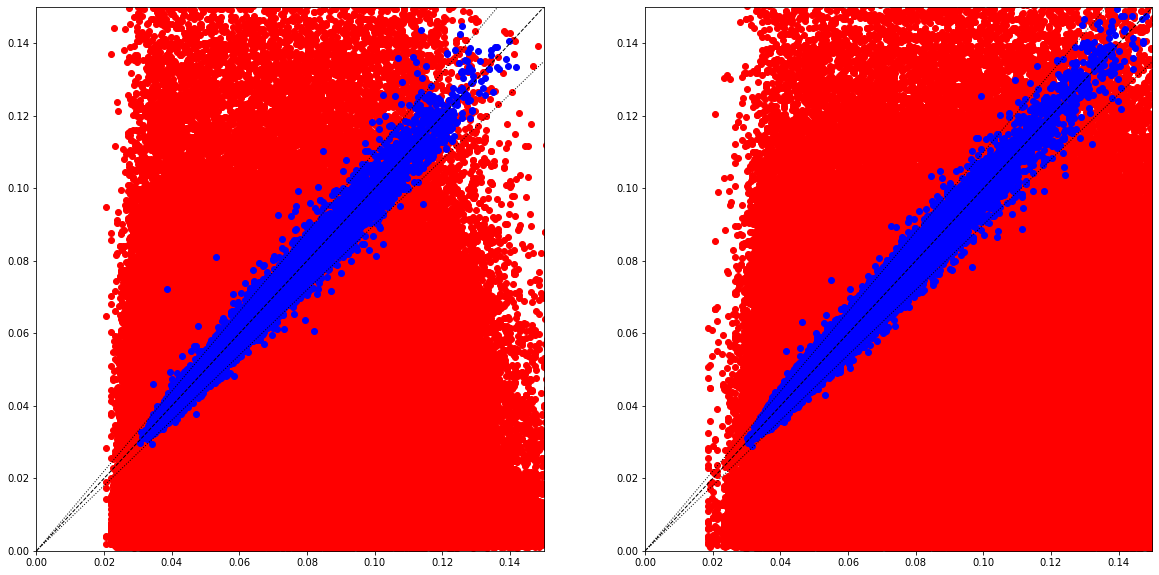

In [29]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_bkg[ "RPId1" ] == 23 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "RPId1" ] == 123 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( df_signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_bkg[ "Arm" ] == 0 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "Arm" ] == 1 ) & ( y_bkg_pred == 0 )
    msk_sig_1 = ( df_signal[ "Arm" ] == 0 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "Arm" ] == 1 ) & ( y_sig_pred == 1 )
    
axes[0].plot( df_bkg[ "Xi" ][ msk_bkg_1 ], df_bkg[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( df_signal[ "Xi" ][ msk_sig_1 ], df_signal[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_bkg[ "Xi" ][ msk_bkg_2 ], df_bkg[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( df_signal[ "Xi" ][ msk_sig_2 ], df_signal[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(0.0, 0.15)

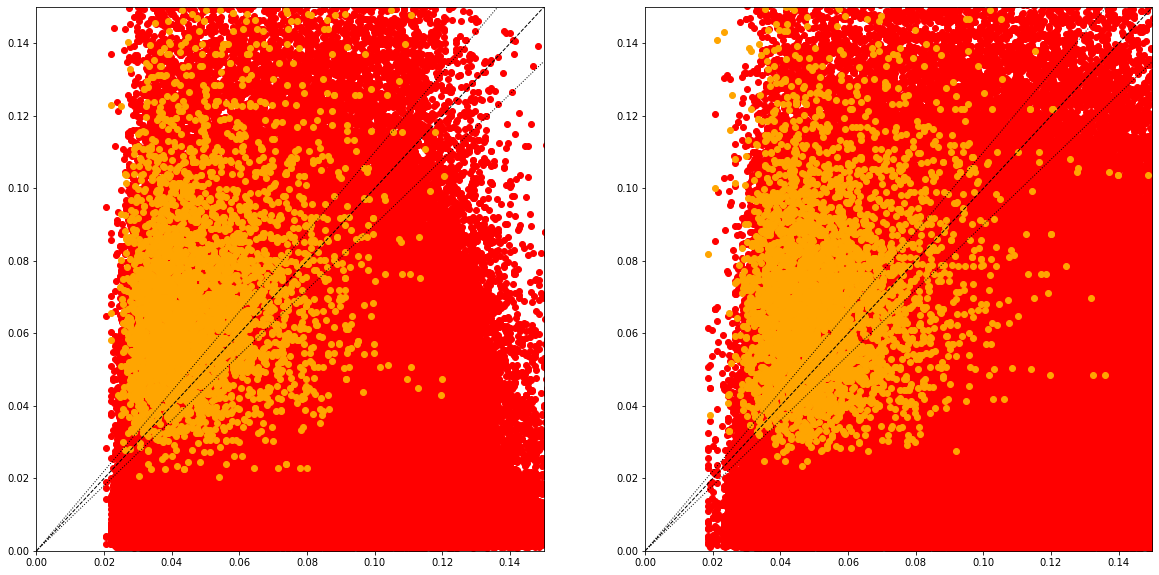

In [30]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_bkgerr_1 = None
msk_bkgerr_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_bkg[ "RPId1" ] == 23 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "RPId1" ] == 123 ) & ( y_bkg_pred == 0 )
    msk_bkgerr_1 = ( df_bkg[ "RPId1" ] == 23 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( df_bkg[ "RPId1" ] == 123 ) & ( y_bkg_pred == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_bkg[ "Arm" ] == 0 ) & ( y_bkg_pred == 0 )
    msk_bkg_2 = ( df_bkg[ "Arm" ] == 1 ) & ( y_bkg_pred == 0 )
    msk_bkgerr_1 = ( df_bkg[ "Arm" ] == 0 ) & ( y_bkg_pred == 1 )
    msk_bkgerr_2 = ( df_bkg[ "Arm" ] == 1 ) & ( y_bkg_pred == 1 )
    
axes[0].plot( df_bkg[ "Xi" ][ msk_bkg_1 ], df_bkg[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( df_bkg[ "Xi" ][ msk_bkgerr_1 ], df_bkg[ "XiMuMuPlus" ][ msk_bkgerr_1 ], 'o', color='orange' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_bkg[ "Xi" ][ msk_bkg_2 ], df_bkg[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( df_bkg[ "Xi" ][ msk_bkgerr_2 ], df_bkg[ "XiMuMuMinus" ][ msk_bkgerr_2 ], 'o', color='orange' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(0.0, 0.15)

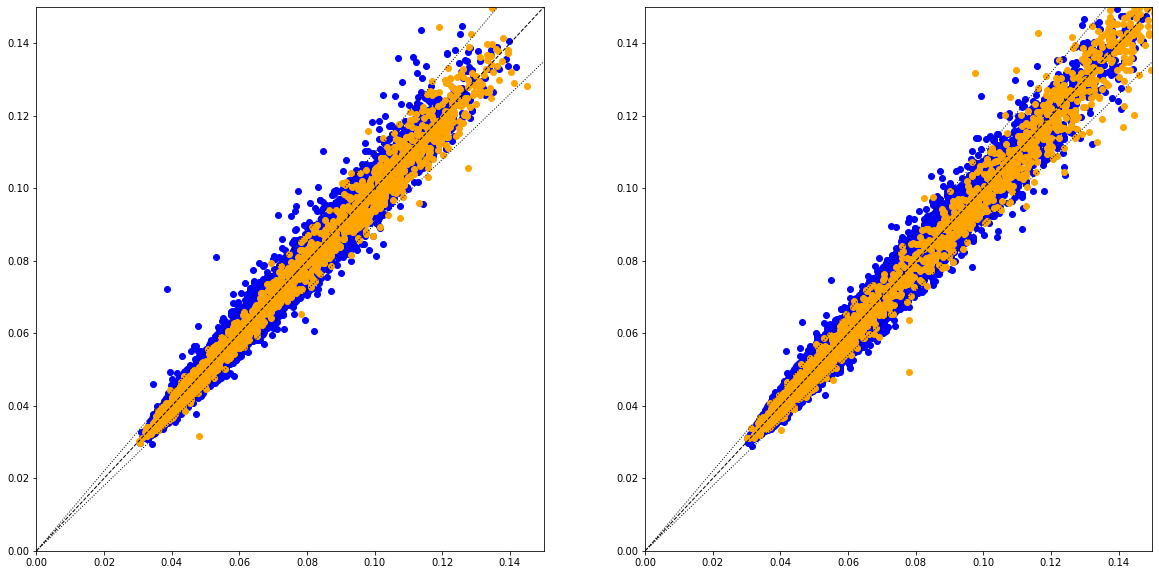

In [31]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_sigerr_1 = None
msk_sigerr_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_sigerr_1 = ( df_signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( df_signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 0 )
    msk_sig_1 = ( df_signal[ "RPId1" ] == 23 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "RPId1" ] == 123 ) & ( y_sig_pred == 1 )
elif proton_selection == "MultiRP":
    msk_sigerr_1 = ( df_signal[ "Arm" ] == 0 ) & ( y_sig_pred == 0 )
    msk_sigerr_2 = ( df_signal[ "Arm" ] == 1 ) & ( y_sig_pred == 0 )
    msk_sig_1 = ( df_signal[ "Arm" ] == 0 ) & ( y_sig_pred == 1 )
    msk_sig_2 = ( df_signal[ "Arm" ] == 1 ) & ( y_sig_pred == 1 )

axes[0].plot( df_signal[ "Xi" ][ msk_sig_1 ], df_signal[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( df_signal[ "Xi" ][ msk_sigerr_1 ], df_signal[ "XiMuMuPlus" ][ msk_sigerr_1 ], 'o', color='orange' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_signal[ "Xi" ][ msk_sig_2 ], df_signal[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( df_signal[ "Xi" ][ msk_sigerr_2 ], df_signal[ "XiMuMuMinus" ][ msk_sigerr_2 ], 'o', color='orange' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

## Data

In [32]:
df_data_list = []
df_counts_data_list = []

fileNames = [
    'output/output-UL2017B-PreSel.h5',
    'output/output-UL2017C1-PreSel.h5',
    'output/output-UL2017E-PreSel.h5',
    'output/output-UL2017F1-PreSel.h5'
]

for file_ in fileNames:
    with h5py.File( file_, 'r' ) as f:
        print ( f )
        print ( list(f.keys()) )
        dset = f['protons']
        print ( dset.shape )
        print ( dset[:,:] )
        
        dset_columns = f['columns']
        print ( dset_columns.shape )
        columns = list( dset_columns )
        print ( columns )
        columns_str = [ item.decode("utf-8") for item in columns ]
        print ( columns_str )

        dset_selections = f['selections']
        selections_ = [ item.decode("utf-8") for item in dset_selections ]
        print ( selections_ )  
        
        dset_counts = f['event_counts']
        df_counts_data_list.append( pd.Series( dset_counts, index=selections_ ) )
        print ( df_counts_data_list[-1] )
        
        chunk_size = 1000000
        entries = dset.shape[0]
        start_ = list( range( 0, entries, chunk_size ) )
        stop_ = start_[1:]
        stop_.append( entries )
        print ( start_ )
        print ( stop_ )
        for idx in range( len( start_ ) ):
            print ( start_[idx], stop_[idx] )
            #print ( dset[ start_[idx] : stop_[idx] ] )
            df_ = pd.DataFrame( dset[ start_[idx] : stop_[idx] ], columns=columns_str )
            df_ = df_[ ['Run', 'LumiSection', 'EventNum', 'CrossingAngle', 
                        'MultiRP', 'Arm', 'RPId1', 'RPId2', 'TrackX1', 'TrackY1', 'TrackX2', 'TrackY2',
                        'Xi', 'T', 'ThX', 'ThY', 'Time',
                        'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMuPlus', 'XiMuMuMinus'] ].astype( { "Run": "int64", "LumiSection": "int64", "EventNum": "int64", "MultiRP": "int32", "Arm": "int32", "RPId1": "int32", "RPId2": "int32", "ExtraPfCands": "int32" } )
            df_data_list.append( df_ )
            print ( df_data_list[-1].head() )
            print ( len( df_data_list[-1] ) )
        

<HDF5 file "output-UL2017B-PreSel.h5" (mode r)>
['columns', 'event_counts', 'protons', 'selections']
(107075, 38)
[[2.9722700e+05 5.3000000e+01 2.2970000e+03 ... 9.8301208e-01
  5.6195408e-02 4.0912917e-03]
 [2.9722700e+05 5.5000000e+01 8.6700000e+02 ... 1.3261172e-01
  1.9532344e-03 4.8346210e-02]
 [2.9722700e+05 5.5000000e+01 8.6700000e+02 ... 1.3261172e-01
  1.9532344e-03 4.8346210e-02]
 ...
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]
 [2.9906200e+05 1.3300000e+02 1.7210000e+03 ... 6.6481882e-01
  3.5217716e-03 7.5678416e-02]]
(38,)
[b'Run', b'LumiSection', b'BX', b'EventNum', b'CrossingAngle', b'MultiRP', b'Arm', b'RPId1', b'RPId2', b'TrackX1', b'TrackY1', b'TrackX2', b'TrackY2', b'Xi', b'T', b'ThX', b'ThY', b'Time', b'TrackThX_SingleRP', b'TrackThY_SingleRP', b'Track1ThX_MultiRP', b'Track1ThY_MultiRP', b'Track2ThX_MultiRP', b'Track2ThY_Multi

In [33]:
df_counts_data = df_counts_data_list[0];
for idx in range( 1, len(df_counts_data_list) ):
    df_counts_data = df_counts_data.add( df_counts_data_list[idx] )
df_counts_data

All        43455978
Muon         422801
Vertex       389118
Protons      315084
dtype: int64

In [34]:
df_data = pd.concat( df_data_list ) 

In [35]:
msk_data = ( df_data["InvMass"] >= 110. )

msk1_data = None
msk2_data = None
if proton_selection == "SingleRP":
    # Single-RP in pixel stations
    msk1_arm = ( df_data["RPId1"] == 23 )
    msk2_arm = ( df_data["RPId1"] == 123 )
    df_data[ "XiMuMu" ] = np.nan
    df_data[ "XiMuMu" ].where( ~msk1_arm, df_data[ "XiMuMuPlus" ], inplace=True )
    df_data[ "XiMuMu" ].where( ~msk2_arm, df_data[ "XiMuMuMinus" ], inplace=True )
    msk1_data = msk_data & ( df_data["MultiRP"] == 0) & msk1_arm
    msk2_data = msk_data & ( df_data["MultiRP"] == 0) & msk2_arm
elif proton_selection == "MultiRP":
    # Multi-RP
    msk1_arm = ( df_data["Arm"] == 0 )
    msk2_arm = ( df_data["Arm"] == 1 )
    df_data[ "XiMuMu" ] = np.nan
    df_data[ "XiMuMu" ].where( ~msk1_arm, df_data[ "XiMuMuPlus" ], inplace=True )
    df_data[ "XiMuMu" ].where( ~msk2_arm, df_data[ "XiMuMuMinus" ], inplace=True )
    msk1_data = msk_data & ( df_data["MultiRP"] == 1 ) & msk1_arm
    msk2_data = msk_data & ( df_data["MultiRP"] == 1 ) & msk2_arm

df_data = df_data[ msk1_data | msk2_data ]
df_data[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,ThY,Time,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu
3,297227,55,38079656,120.0,1,1,103,123,4.577393,1.367676,...,-0.000014,0.0,63.340645,62.493637,123.616516,27,0.132612,0.001953,0.048346,0.048346
6,297227,56,38791640,120.0,1,1,103,123,8.585938,2.644531,...,0.000024,0.0,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.062855
39,297227,71,50687028,120.0,1,0,3,23,5.214844,-0.371826,...,0.000093,0.0,126.357605,113.611771,270.992401,27,0.016921,0.010428,0.041786,0.010428
48,297227,73,52238048,120.0,1,1,103,123,5.372803,0.135132,...,0.000031,0.0,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333
51,297227,74,52411720,120.0,1,1,103,123,4.895752,-0.607605,...,0.000121,0.0,111.228539,96.216682,211.304825,37,0.308182,0.016115,0.019881,0.019881
61,297227,75,53449356,120.0,1,0,3,23,12.326172,-1.268066,...,0.000065,0.0,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.019344
70,297227,76,54126336,120.0,1,1,103,123,3.238647,1.550049,...,-0.000029,0.0,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.006129
73,297227,78,56185408,120.0,1,1,103,123,5.210449,-1.396362,...,0.000116,0.0,57.649437,56.255272,111.417343,25,0.141610,0.014498,0.005325,0.005325
101,297227,91,66200792,120.0,1,1,103,123,11.390625,4.910645,...,0.000011,0.0,73.228600,69.507820,143.137054,22,0.010714,0.009334,0.013000,0.013000
109,297227,94,68360752,120.0,1,0,3,23,5.153076,1.484619,...,-0.000047,0.0,82.481186,53.035610,110.397728,63,0.410358,0.090327,0.001269,0.090327


In [36]:
X_data = df_data[ ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu'] ]
X_data[:20]

,Xi,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMu
3,0.067306,63.340645,62.493637,123.616516,27,0.132612,0.048346
6,0.102869,65.270454,65.022888,152.786011,29,0.058782,0.062855
39,0.039614,126.357605,113.611771,270.992401,27,0.016921,0.010428
48,0.052213,86.516212,56.114479,138.904510,10,0.060892,0.008333
51,0.045295,111.228539,96.216682,211.304825,37,0.308182,0.019881
61,0.104492,74.069061,62.750038,159.699677,53,0.023202,0.019344
70,0.055042,75.266441,69.694183,223.032425,59,0.145185,0.006129
73,0.056894,57.649437,56.255272,111.417343,25,0.141610,0.005325
101,0.122168,73.228600,69.507820,143.137054,22,0.010714,0.013000
109,0.052344,82.481186,53.035610,110.397728,63,0.410358,0.090327


In [37]:
X_data_scaled = None
y_data_proba = None
y_data = None

if load_keras_model:
    X_data_scaled = scaler.transform( X_data )
    print( X_data_scaled )
   
    y_data_proba = clf.predict( X_data_scaled )
    y_data_proba = y_data_proba.flatten()
    y_data = ( y_data_proba >= prob_cut ).astype( "int32" )
    y_data = y_data.flatten()
else:
    y_data_proba = clf.predict_proba( X_data )[:,1]
    y_data = clf.predict( X_data )

print ( y_data_proba )
print ( y_data )

[[-0.5563401  -0.5744786  -0.28131197 ... -0.46477492  0.21392028
   0.88214353]
 [ 0.49004049 -0.53051525 -0.19791074 ... -0.37425727 -0.2927716
   1.41514676]
 [-1.3711185   0.86112246  1.40429177 ... -0.46477492 -0.58005913
  -0.51084712]
 ...
 [ 0.70515815 -0.54898794 -0.37314014 ...  1.34557816 -0.59459285
  -0.16170482]
 [ 0.79438004  0.57811987 -0.17825253 ...  0.39514279  0.04615188
  -0.18017707]
 [ 0.27872432 -0.71680591 -0.55691019 ... -1.55098678 -0.69091332
  -0.06655122]]
[0.01950168 0.01927456 0.01650221 ... 0.00055176 0.00031828 0.01232114]
[0 0 0 ... 0 0 0]


(0.0, 0.15)

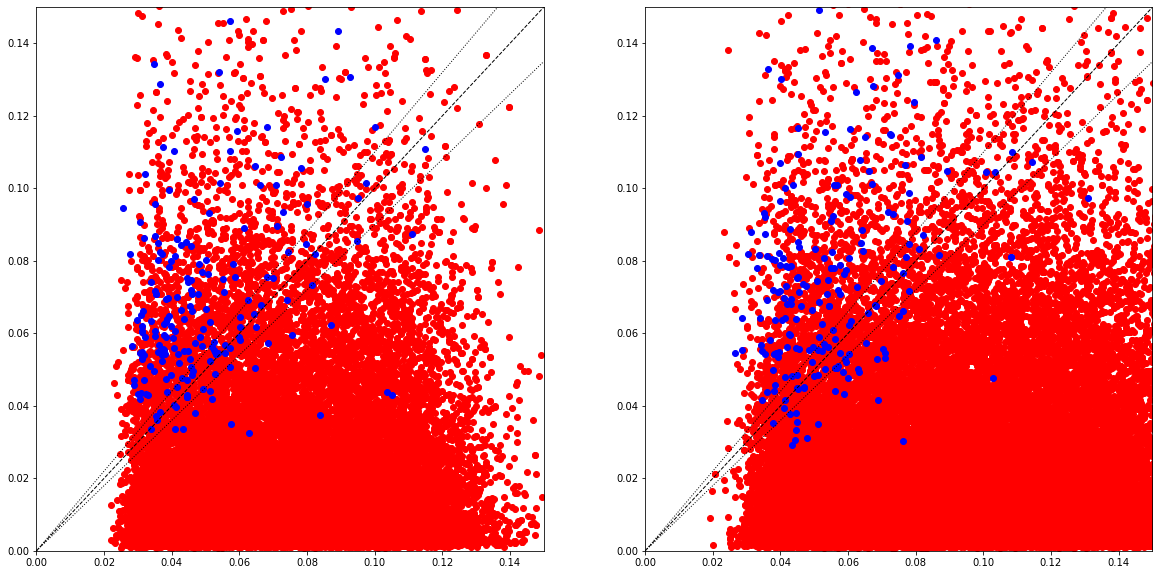

In [38]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

msk_bkg_1 = None
msk_bkg_2 = None
msk_sig_1 = None
msk_sig_2 = None
if proton_selection == "SingleRP":
    msk_bkg_1 = ( df_data[ "RPId1" ] == 23 ) & ( y_data == 0 )
    msk_bkg_2 = ( df_data[ "RPId1" ] == 123 ) & ( y_data == 0 )
    msk_sig_1 = ( df_data[ "RPId1" ] == 23 ) & ( y_data == 1 )
    msk_sig_2 = ( df_data[ "RPId1" ] == 123 ) & ( y_data == 1 )
elif proton_selection == "MultiRP":
    msk_bkg_1 = ( df_data[ "Arm" ] == 0 ) & ( y_data == 0 )
    msk_bkg_2 = ( df_data[ "Arm" ] == 1 ) & ( y_data == 0 )
    msk_sig_1 = ( df_data[ "Arm" ] == 0 ) & ( y_data == 1 )
    msk_sig_2 = ( df_data[ "Arm" ] == 1 ) & ( y_data == 1 )

axes[0].plot( df_data[ "Xi" ][ msk_bkg_1 ], df_data[ "XiMuMuPlus" ][ msk_bkg_1 ], 'ro' )
axes[0].plot( df_data[ "Xi" ][ msk_sig_1 ], df_data[ "XiMuMuPlus" ][ msk_sig_1 ], 'bo' )
axes[0].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[0].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[0].set_xlim(0.,0.15)
axes[0].set_ylim(0.,0.15)
axes[1].plot( df_data[ "Xi" ][ msk_bkg_2 ], df_data[ "XiMuMuMinus" ][ msk_bkg_2 ], 'ro' )
axes[1].plot( df_data[ "Xi" ][ msk_sig_2 ], df_data[ "XiMuMuMinus" ][ msk_sig_2 ], 'bo' )
axes[1].plot( (0.,0.15), (0.,0.15), 'k--', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,0.90*0.15), 'k:', linewidth=1 )
axes[1].plot( (0.,0.15), (0.,1.10*0.15), 'k:', linewidth=1 )
axes[1].set_xlim(0.,0.15)
axes[1].set_ylim(0.,0.15)

(array([59.72139238, 61.62594703, 62.85028988, 58.49704858, 59.72137065,
        52.6473284 , 61.35389904, 53.19148684, 49.2463382 , 59.72135327,
        53.32755748, 55.50412787, 52.78339873, 51.42300186, 58.63303704,
        59.58538311, 54.95996975, 55.3681528 , 52.10313964, 52.51125823,
        54.27989849, 54.00769305, 44.75700507, 51.15086294, 53.05553987,
        50.74274435, 46.66155848, 42.98859128, 43.39660978, 45.57324224,
        50.19858623, 43.39671082, 49.38234906, 48.83819094, 40.94789826,
        44.07691005, 48.1579933 , 48.29403283, 46.52562727, 48.02184196,
        42.98859128, 43.53275067, 38.22701867, 45.84542805, 43.80483036,
        43.80462638, 41.35611313, 39.99552843, 41.76423267, 39.45155529]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.01

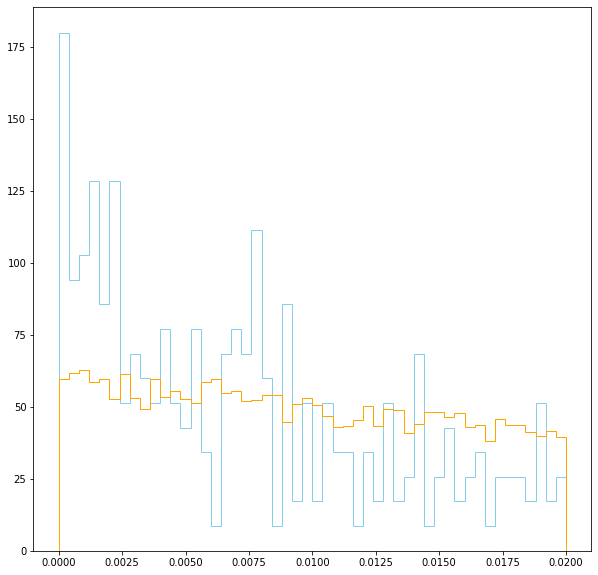

In [39]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "Acopl" ][ y_data == 1 ], histtype='step', color='skyblue', bins=50, range=(0.,0.02), density=True )
plt.hist( df_data[ "Acopl" ][ y_data == 0 ], histtype='step', color='orange', bins=50, range=(0.,0.02), density=True )

(array([0.00281926, 0.00239024, 0.00335043, 0.00516864, 0.0065987 ,
        0.00792662, 0.00858036, 0.00976527, 0.01070502, 0.01313612,
        0.01327913, 0.01550593, 0.01560808, 0.0176306 , 0.01814133,
        0.02059286, 0.02120574, 0.02237022, 0.02208421, 0.02545507,
        0.02310568, 0.02455617, 0.02308525, 0.02447445, 0.02608838,
        0.02567979, 0.02508734, 0.02629267, 0.02529163, 0.02598623,
        0.02574108, 0.02745715, 0.02649697, 0.02657868, 0.02549592,
        0.02602709, 0.02529163, 0.02484218, 0.02398415, 0.02429059,
        0.0235347 , 0.02459703, 0.02216593, 0.02310568, 0.02132832,
        0.02098102, 0.02038857, 0.02016384, 0.01818219, 0.03738585]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
        39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50.]),
 [<matplotlib.patches.Polygon

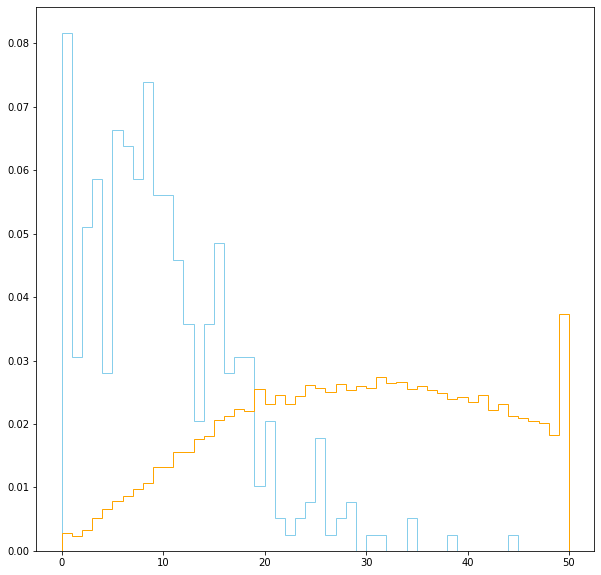

In [40]:
fig = plt.figure( figsize=(10,10) )
plt.hist( df_data[ "ExtraPfCands" ][ y_data == 1 ], histtype='step', color='skyblue', bins=50, range=(0,50), density=True )
plt.hist( df_data[ "ExtraPfCands" ][ y_data == 0 ], histtype='step', color='orange', bins=50, range=(0,50), density=True )

### Append data table with classifier prediction and probability

In [41]:
#vars_ = ['Xi', 'Muon0Pt', 'Muon1Pt', 'InvMass', 'ExtraPfCands', 'Acopl', 'XiMuMu']
#df_data[ "category" ] = clf.predict( df_data[ vars_ ] ).astype("int32")
#df_data[ "probability" ] = clf.predict_proba( df_data[ vars_ ] )[:,1]
df_data[ "category" ] = y_data
df_data[ "probability" ] = y_data_proba
df_data[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu,category,probability
3,297227,55,38079656,120.0,1,1,103,123,4.577393,1.367676,...,63.340645,62.493637,123.616516,27,0.132612,0.001953,0.048346,0.048346,0,1.950168e-02
6,297227,56,38791640,120.0,1,1,103,123,8.585938,2.644531,...,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.062855,0,1.927456e-02
39,297227,71,50687028,120.0,1,0,3,23,5.214844,-0.371826,...,126.357605,113.611771,270.992401,27,0.016921,0.010428,0.041786,0.010428,0,1.650221e-02
48,297227,73,52238048,120.0,1,1,103,123,5.372803,0.135132,...,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333,0,3.599833e-03
51,297227,74,52411720,120.0,1,1,103,123,4.895752,-0.607605,...,111.228539,96.216682,211.304825,37,0.308182,0.016115,0.019881,0.019881,0,1.085650e-03
61,297227,75,53449356,120.0,1,0,3,23,12.326172,-1.268066,...,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.019344,0,9.193211e-04
70,297227,76,54126336,120.0,1,1,103,123,3.238647,1.550049,...,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.006129,0,3.663897e-04
73,297227,78,56185408,120.0,1,1,103,123,5.210449,-1.396362,...,57.649437,56.255272,111.417343,25,0.141610,0.014498,0.005325,0.005325,0,4.326558e-04
101,297227,91,66200792,120.0,1,1,103,123,11.390625,4.910645,...,73.228600,69.507820,143.137054,22,0.010714,0.009334,0.013000,0.013000,0,8.773311e-04
109,297227,94,68360752,120.0,1,0,3,23,5.153076,1.484619,...,82.481186,53.035610,110.397728,63,0.410358,0.090327,0.001269,0.090327,0,1.838972e-03


In [42]:
#df_bkg[ "category" ] = clf.predict( df_bkg[ vars_ ] ).astype("int32")
#df_bkg[ "probability" ] = clf.predict_proba( df_bkg[ vars_ ] )[:,1]
df_bkg[ "category" ] = y_bkg_pred
df_bkg[ "probability" ] = y_bkg_proba
df_bkg[:20]

,Run,LumiSection,EventNum,CrossingAngle,MultiRP,Arm,RPId1,RPId2,TrackX1,TrackY1,...,Muon0Pt,Muon1Pt,InvMass,ExtraPfCands,Acopl,XiMuMuPlus,XiMuMuMinus,XiMuMu,category,probability
10,297227,56,38791640,120.0,1,0,3,23,7.063232,1.953613,...,65.270454,65.022888,152.786011,29,0.058782,0.002211,0.062855,0.002211,0,0.000350
20,297227,58,40362008,120.0,1,0,3,23,7.391113,2.280518,...,80.369690,68.791176,228.323425,10,0.271141,0.028539,0.011619,0.028539,0,0.004767
33,297227,60,41478176,120.0,1,0,3,23,6.782959,1.464966,...,114.150841,93.884605,323.668549,40,0.157789,0.035037,0.018197,0.035037,0,0.016190
47,297227,63,44189296,120.0,1,0,3,23,13.382812,-1.072510,...,138.408752,108.538467,245.222839,53,0.008506,0.033806,0.010684,0.033806,0,0.015187
69,297227,73,52238048,120.0,1,1,103,123,8.629883,1.481323,...,86.516212,56.114479,138.904510,10,0.060892,0.014483,0.008333,0.008333,0,0.000703
84,297227,75,53449356,120.0,1,1,103,123,5.546875,1.592651,...,74.069061,62.750038,159.699677,53,0.023202,0.019344,0.007848,0.007848,0,0.000668
93,297227,76,54126336,120.0,1,0,3,23,8.200684,3.784912,...,75.266441,69.694183,223.032425,59,0.145185,0.049092,0.006129,0.049092,0,0.007838
111,297227,78,55898044,120.0,1,1,103,123,3.611084,1.855103,...,58.097786,53.140121,126.642601,84,0.273834,0.032531,0.003312,0.003312,0,0.000013
118,297227,79,56863080,120.0,1,1,103,123,3.396606,1.380615,...,61.966732,50.172760,127.597572,21,0.026694,0.001631,0.059633,0.059633,0,0.095249
138,297227,86,61943160,120.0,1,0,3,23,7.637451,1.072144,...,91.612099,71.395660,163.843567,62,0.095938,0.016999,0.009692,0.016999,0,0.000734


y max. = 37606.85489500588


(0.0, 50.0)

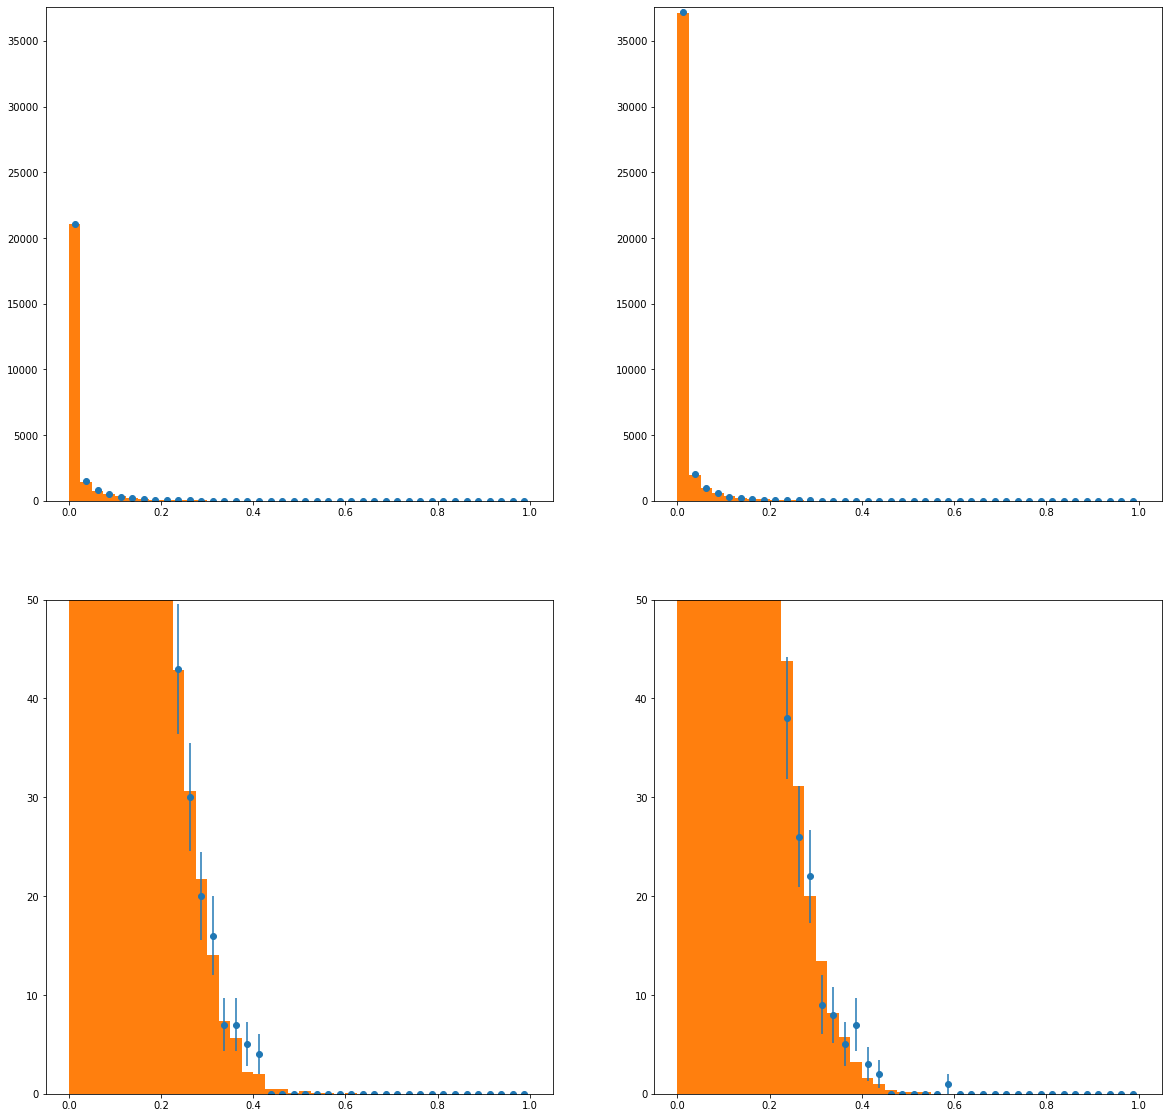

In [43]:
fig, axes = plt.subplots( 2, 2, figsize=(20,20) )

var_ = "probability"
bins_ = 40
range_ = (0.,1.)

msk_data_1 = None
msk_data_2 = None
if proton_selection == "SingleRP":
    msk_data_1 = ( df_data[ "RPId1" ] == 23 )
    msk_data_2 = ( df_data[ "RPId1" ] == 123 )
elif proton_selection == "MultiRP":
    msk_data_1 = ( df_data[ "Arm" ] == 0 )
    msk_data_2 = ( df_data[ "Arm" ] == 1 )
    
counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0,0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')
axes[1,0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[0,1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')
axes[1,1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

msk_bkg_pred_1 = None
msk_bkg_pred_2 = None
if proton_selection == "SingleRP":
    msk_bkg_pred_1 = ( df_bkg[ "RPId1" ] == 23 )
    msk_bkg_pred_2 = ( df_bkg[ "RPId1" ] == 123 )
elif proton_selection == "MultiRP":
    msk_bkg_pred_1 = ( df_bkg[ "Arm" ] == 0 )
    msk_bkg_pred_2 = ( df_bkg[ "Arm" ] == 1 )

weights_1 = None
if resample_factor > 1:
    weights_1 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_1 ], ( 1./resample_factor ) )

weights_2 = None
if resample_factor > 1:
    weights_2 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_2 ], ( 1./resample_factor ) )

axes[0,0].hist( df_bkg[ var_ ][ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )
axes[1,0].hist( df_bkg[ var_ ][ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )

axes[0,1].hist( df_bkg[ var_ ][ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )
axes[1,1].hist( df_bkg[ var_ ][ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )

axes[0,0].set_ylim( top=y_max )
axes[0,1].set_ylim( top=y_max )
#axes[0].set_yscale('log')
#axes[1].set_yscale('log')
axes[1,0].set_ylim( top=50. )
axes[1,1].set_ylim( top=50. )

### Plot events classified as signal

y max. = 27.717797887081346


(0.0, 27.717797887081346)

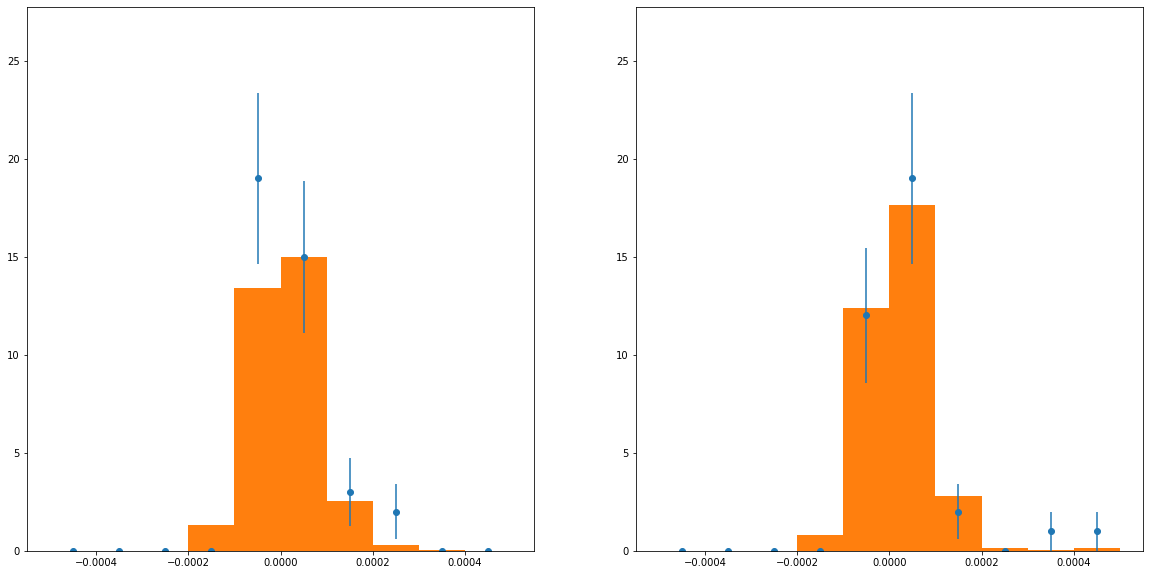

In [44]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

#var_ = "Xi"
#bins_ = 10
#range_ = (0.,0.2)

var_ = "ThX"
bins_ = 10
range_ = (-0.0005,0.0005)

#var_ = "ThY"
#bins_ = 10
#range_ = (-0.0005,0.0005)

#var_ = "T"
#bins_ = 10
#range_ = (-4.,0.)

#var_ = "Time"
#bins_ = 20
#range_ = (-0.5,0.5)

#var_ = "Muon0Pt"
#bins_ = 10
#range_ = (50.,200.)

#var_ = "InvMass"
#bins_ = 10
#range_ = (110.,500.)

#var_ = "Acopl"
#bins_ = 10
#range_ = (0.,0.01)

#var_ = "ExtraPfCands"
#bins_ = 20
#range_ = (0,20)

#prob_cut_sel = prob_cut
prob_cut_sel = 0.30

#msk_data_1 = ( df_data[ "category" ] == 1 )
#msk_data_2 = ( df_data[ "category" ] == 1 )
msk_data_1 = ( df_data[ "probability" ] >= prob_cut_sel )
msk_data_2 = ( df_data[ "probability" ] >= prob_cut_sel )
if proton_selection == "SingleRP":
    msk_data_1 = ( df_data[ "RPId1" ] == 23 ) & msk_data_1
    msk_data_2 = ( df_data[ "RPId1" ] == 123 ) & msk_data_2
elif proton_selection == "MultiRP":
    msk_data_1 = ( df_data[ "Arm" ] == 0 ) & msk_data_1
    msk_data_2 = ( df_data[ "Arm" ] == 1 ) & msk_data_2

counts_1, bin_edges_1 = np.histogram( df_data[ var_ ][ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

counts_2, bin_edges_2 = np.histogram( df_data[ var_ ][ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

#msk_bkg_pred_1 = ( df_bkg[ "category" ] == 1 )
#msk_bkg_pred_2 = ( df_bkg[ "category" ] == 1 )
msk_bkg_pred_1 = ( df_bkg[ "probability" ] >= prob_cut_sel )
msk_bkg_pred_2 = ( df_bkg[ "probability" ] >= prob_cut_sel )
if proton_selection == "SingleRP":
    msk_bkg_pred_1 = ( df_bkg[ "RPId1" ] == 23 ) & msk_bkg_pred_1
    msk_bkg_pred_2 = ( df_bkg[ "RPId1" ] == 123 ) & msk_bkg_pred_2
elif proton_selection == "MultiRP":
    msk_bkg_pred_1 = ( df_bkg[ "Arm" ] == 0 ) & msk_bkg_pred_1
    msk_bkg_pred_2 = ( df_bkg[ "Arm" ] == 1 ) & msk_bkg_pred_2

weights_1 = None
if resample_factor > 1:
    weights_1 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_1 ], ( 1./resample_factor ) )

weights_2 = None
if resample_factor > 1:
    weights_2 = np.full_like( df_bkg[ var_ ][ msk_bkg_pred_2 ], ( 1./resample_factor ) )

axes[0].hist( df_bkg[ var_ ][ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )
axes[1].hist( df_bkg[ var_ ][ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )
    
axes[0].set_ylim( top=y_max )
axes[1].set_ylim( top=y_max )

y max. = 15.0


(0.0, 15.0)

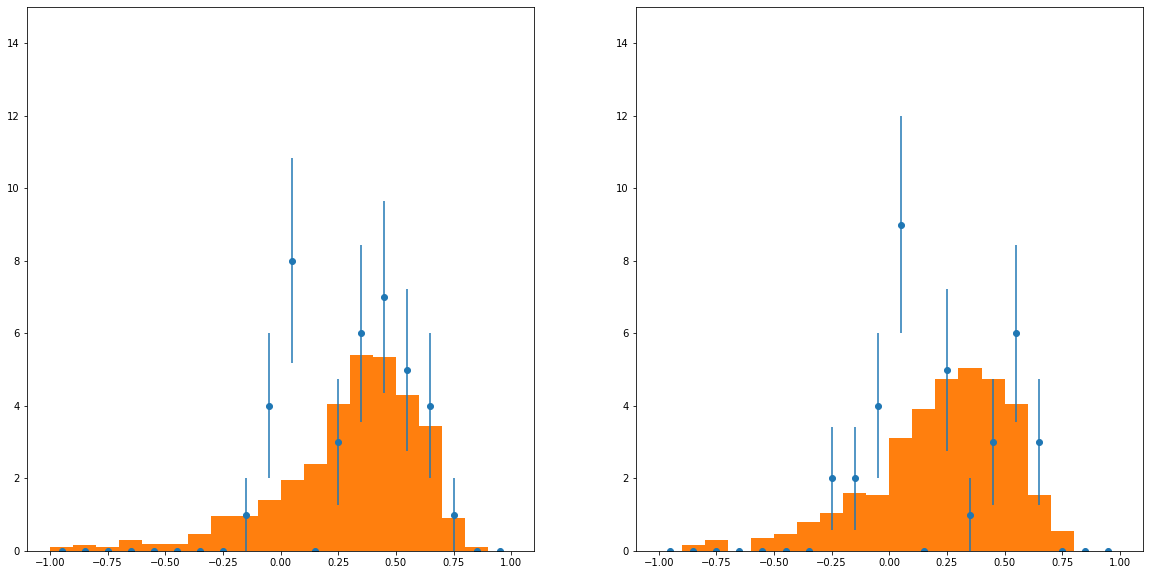

In [45]:
fig, axes = plt.subplots( 1, 2, figsize=(20,10) )

bins_ = 20
range_ = (-1.,1.)

vals_data = ( 1. - df_data[ "Xi" ] / df_data[ "XiMuMu" ] )

counts_1, bin_edges_1 = np.histogram( vals_data[ msk_data_1 ], bins=bins_, range=range_ )
errors_1 = np.sqrt( counts_1 )
bin_centres_1 = ( bin_edges_1[:-1] + bin_edges_1[1:] ) / 2.
axes[0].errorbar(bin_centres_1, counts_1, yerr=errors_1, fmt='o')

counts_2, bin_edges_2 = np.histogram( vals_data[ msk_data_2 ], bins=bins_, range=range_ )
errors_2 = np.sqrt( counts_2 )
bin_centres_2 = ( bin_edges_2[:-1] + bin_edges_2[1:] ) / 2.
axes[1].errorbar(bin_centres_2, counts_2, yerr=errors_2, fmt='o')

idx_ymax_ = np.argmax( np.concatenate( [counts_1, counts_2] ) )
y_max = np.concatenate( [counts_1, counts_2] )[idx_ymax_] + 2*np.concatenate( [errors_1, errors_2] )[idx_ymax_]
print ( "y max. = {}".format(y_max) )

vals_bkg = ( 1. - df_bkg[ "Xi" ] / df_bkg[ "XiMuMu" ] )

axes[0].hist( vals_bkg[ msk_bkg_pred_1 ], bins=bins_, range=range_, weights=weights_1 )
axes[1].hist( vals_bkg[ msk_bkg_pred_2 ], bins=bins_, range=range_, weights=weights_2 )
    
axes[0].set_ylim( top=y_max )
axes[1].set_ylim( top=y_max )

### References

In [46]:
np.info( np.ndarray.flatten )

a.flatten(order='C')

Return a copy of the array collapsed into one dimension.

Parameters
----------
order : {'C', 'F', 'A', 'K'}, optional
    'C' means to flatten in row-major (C-style) order.
    'F' means to flatten in column-major (Fortran-
    style) order. 'A' means to flatten in column-major
    order if `a` is Fortran *contiguous* in memory,
    row-major order otherwise. 'K' means to flatten
    `a` in the order the elements occur in memory.
    The default is 'C'.

Returns
-------
y : ndarray
    A copy of the input array, flattened to one dimension.

See Also
--------
ravel : Return a flattened array.
flat : A 1-D flat iterator over the array.

Examples
--------
>>> a = np.array([[1,2], [3,4]])
>>> a.flatten()
array([1, 2, 3, 4])
>>> a.flatten('F')
array([1, 3, 2, 4])
